In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [6]:
df = pd.read_csv('british_columbia_data.csv') #this is how you read in a .csv file -- similar functions exist for other files, such as read_excel

In [7]:
df

,year,day,maxt,mint,radn,rain,vp,swe
0,1980,1,0.87,-6.82,1.461473,12.86,3.6659,70.94
1,1980,2,1.66,-5.74,1.438108,16.76,3.9830,70.82
2,1980,3,0.03,-11.24,1.913825,10.44,2.5904,81.27
3,1980,4,-4.17,-15.06,2.529183,1.33,1.8981,82.60
4,1980,5,-12.74,-21.26,2.259927,0.00,1.1192,82.60
...,...,...,...,...,...,...,...,...
16055,2023,361,5.31,-4.61,1.896946,13.47,4.3373,302.18
16056,2023,362,7.04,-8.56,2.265442,10.58,3.2009,312.76
16057,2023,363,5.10,-1.80,1.502332,6.30,5.3534,310.99
16058,2023,364,6.02,-3.19,1.834301,14.89,4.8263,309.81


<h1>Exploratory Data Anlysis</h1>
Key things to look at:
<ul>
    <li>The correlations between variables</li>
    <li>The annual daily temperatures averages</li>
    <li>The annual precipitation and snow water equivalent totals</li>
    <li>Any relationships that are particularly apparent based on the correlation matrix</li>
    <li>Days with or without rain/snow</li>
</ul>

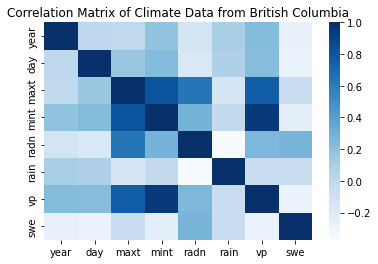

In [14]:
sns.heatmap(df.corr(), cmap = "Blues") #df.corr() makes a correlation matrix based on the data provided in df
plt.title("Correlation Matrix of Climate Data from British Columbia")
plt.show()

In [29]:
#np.zeros creates an aray of all zeros of a certain size, in this case of size 2023-1980 + 1
annual_maxt_average = np.zeros(2023-1980 + 1)
annual_mint_average = np.zeros(2023-1980 + 1)
annual_precip = np.zeros(2023-1980 + 1)
annual_swe = np.zeros(2023-1980 + 1)
#for all of the data in the dataframe, add each value to the proper array bucket (for example, index 0 matches with year 1980)
for i in range(len(df)):
    annual_maxt_average[df['year'][i] - 1980] += df['maxt'][i]
    annual_mint_average[df['year'][i] - 1980] += df['mint'][i]
    
    annual_precip[df['year'][i] - 1980] += df['rain'][i]
    annual_swe[df['year'][i] - 1980] += df['swe'][i]

#this computation divides each element of the lists by 365 (the number of days in a year)
annual_maxt_average = annual_maxt_average / 365
annual_mint_average = annual_mint_average / 365

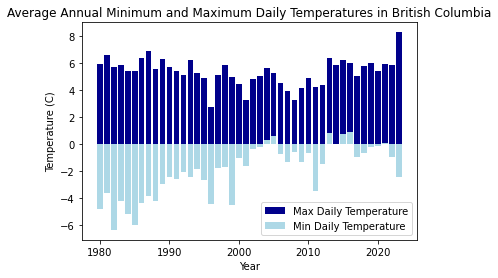

In [31]:
plt.bar(x = np.arange(1980, 2024), height = annual_maxt_average, color = "darkblue", label = "Max Daily Temperature")
plt.bar(x = np.arange(1980, 2024), height = annual_mint_average, color = "lightblue", label = "Min Daily Temperature")
plt.title("Average Annual Minimum and Maximum Daily Temperatures in British Columbia")
plt.legend() #this line required to see the legend -- you can change the location using loc = some number
plt.xlabel("Year")
plt.ylabel("Temperature (C)")
plt.show()

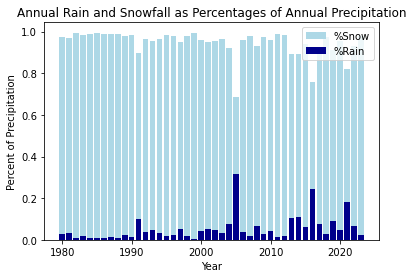

In [39]:
#to get percent of total precipitation that rain and snow are, divide by their sums for the year
plt.bar(x = np.arange(1980, 2024), height = annual_swe / (annual_swe + annual_precip), color = "lightblue", label = "%Snow")
plt.bar(x = np.arange(1980, 2024), height = annual_precip / (annual_swe + annual_precip), color = "darkblue", label = "%Rain")
plt.legend()
plt.title("Annual Rain and Snowfall as Percentages of Annual Precipitation")
plt.xlabel("Year")
plt.ylabel("Percent of Precipitation")
plt.show()

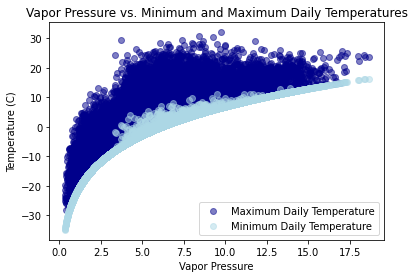

In [45]:
plt.scatter(df['vp'], df['maxt'], color = "darkblue", label = "Maximum Daily Temperature", alpha = 0.5)
plt.scatter(df['vp'], df['mint'], color = "lightblue", label = "Minimum Daily Temperature", alpha = 0.5)
plt.legend()
plt.title("Vapor Pressure vs. Minimum and Maximum Daily Temperatures")
plt.xlabel("Vapor Pressure")
plt.ylabel("Temperature (C)")
plt.show()

In [47]:
days_with_precip = 0
days_without_precip = 0
for i in range(len(df)):
    if df['rain'][i] == 0 and df['swe'][i] == 0:
        days_without_precip += 1
    else:
        days_with_precip += 1
print("Days with Precipitation: " + str(days_with_precip))
print("Days without Precipitation: " + str(days_without_precip))

Days with Precipitation: 14513
Days without Precipitation: 1547


<h1>Cleaning and Labeling</h1>
I have decided that I want to try and predict the percent of rain and snow for precipitation in a given day given the year, day of the year, and the daily temperatures. In order to do this, I need to add columns to my dataset that have the day of the year, the percent snow, and the percent rain. I should remove the days where there is no rain and no precipitation.

In [58]:
days_of_year = np.arange(1, 366)
days = np.tile(days_of_year, (44,1)) #np.tile repeats the given list the specified number of times, in this case 44 since we have 44 years of data with 365 days each
days = np.reshape(days, (365*44,)) #reshape makes it so that it isn't a list of lists, but rather one list
df['DayofYear'] = days #this lets us create a new column in the dataset 

In [63]:
percent_rain = np.array([df['rain'][i]/(df['rain'][i] + df['swe'][i]) for i in range(len(df))]) #these are called list comprehensions and they let you did a computation for each value in a list directly instead of writing multiple lines of code -- same thing can be done with a regular for loop
percent_snow = np.array([df['swe'][i]/(df['rain'][i] + df['swe'][i]) for i in range(len(df))])
df['PercentRain'] = percent_rain
df['PercentSnow'] = percent_snow

/var/folders/x0/gw1brhsj1kj63snw8zc0pr880000gn/T/ipykernel_86824/2974982744.py:1: RuntimeWarning: invalid value encountered in double_scalars
  percent_rain = np.array([df['rain'][i]/(df['rain'][i] + df['swe'][i]) for i in range(len(df))])
/var/folders/x0/gw1brhsj1kj63snw8zc0pr880000gn/T/ipykernel_86824/2974982744.py:2: RuntimeWarning: invalid value encountered in double_scalars
  percent_snow = np.array([df['swe'][i]/(df['rain'][i] + df['swe'][i]) for i in range(len(df))])


In [84]:
not_nan_indices = []
for i in range(len(df)):
    if df['rain'][i] != 0 or df['swe'][i] != 0:
        not_nan_indices.append(i) #wanted to find the places where there are no nans, meaning there is some precipitation because otherwise get 0/0

<h1>Splitting into Training and Testing</h1>
I have decided that I am going to use 80% of my data for training and 20% for testing. My X values are as follows:
<ul>
    <li>Year</li>
    <li>DayofYear</li>
    <li>maxt</li>
    <li>mint</li>
</ul>
My y values are as follows:
<ul>
    <li>PercentRain</li>
    <li>PercentSnow</li>
</ul>

In [85]:
#make sure you get the order right on train/test split function; can easily find sklearn documentation
#selected for the year, day of the year, maxt, and mint columns as the inputs and the outputs as percent rain and percent snow
train_x, test_x, train_y, test_y = train_test_split(df.loc[not_nan_indices, ['year', 'DayofYear', 'maxt', 'mint']], df.loc[not_nan_indices, ['PercentRain', 'PercentSnow']], test_size = 0.2)

<h1>GridSearch for Hyperparameters</h1>
I decided that I was going to use a RandomForestRegressor as my model. RandomForestRegressor has several hyperparameters that I want to tune, specifically:
<ul>
    <li>n_estimators - The numbers of decision trees I am going to generate.</li>
    <li>max_depth - The size and depth of the individual trees that I create.</li>
    <li>max_features - The number of features to consider when looking for best fit (might not be all the features!)</li>
</ul>
I want to do a GridSearch CV to do this. I am going to use the documentation for RandomForestRegressor to come up with random values to try for these parameters and feed them into the grid search to get my best hyperparameters for my model.

In [94]:
#n_estimators, max_depth, and max_features are the hyperparameters we are tuning and we can set them using a python type called a dictionary where each key is mapped to some value 
params = {'n_estimators': np.random.randint(low = 50, high = 150, size = 3), 'max_depth': np.random.randint(low = 25, high = 100, size = 3), 'max_features': [3, 'None']}
rfr = RandomForestRegressor() #creates essentially a 'blank' random forest regressor model that has not been fit yet for parameter tuning and doesn't have any hyperparameters tuned 

In [95]:
gs = GridSearchCV(rfr, params) #set up a grid search by passing in the model and the parameters to hypertune

In [96]:
gs.fit(train_x, train_y) #fits a bunch of different models, assesses them, and returns the best parameters based on the inputted training and testing data 

/Users/elizabethcucuzzella/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/elizabethcucuzzella/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/elizabethcucuzzella/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/elizabethcucuzzella/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in 

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([41, 65, 83]),
                         'max_features': [3, 'None'],
                         'n_estimators': array([ 68,  71, 128])})

In [98]:
best_params = gs.best_params_ #save the best parameters 

<h1>Creating the Model</h1>
Now that we have the best params, we can fit the RandomForestRegressor and predict using our training and testing data sets.

In [99]:
#use the best parameters from above to create a random forest regressor 
rfr_ = RandomForestRegressor(max_depth = best_params['max_depth'], max_features = best_params['max_features'], n_estimators = best_params['n_estimators'])

In [100]:
rfr_.fit(train_x, train_y) #fit using the training x and y values

RandomForestRegressor(max_depth=65, max_features=3, n_estimators=128)

In [101]:
predict_train_y = rfr_.predict(train_x)
predict_test_y = rfr_.predict(test_x)

<h1>Assessing Accuracy</h1>
Now we need to assess how we did on both training and testing data to ensure that our model is generalizable. There are many ways of doing this. We have numeric data and are conducting regression. Therefore, we can use R^2 which tells us what percent of variability in our data is accounted for by our model. We can also observe these values between rain and snow prediction.

In [117]:
rsquared_train_rain = stats.linregress(np.array(train_y['PercentRain']), predict_train_y[:,0]).rvalue ** 2

In [118]:
rsquared_train_snow = stats.linregress(np.array(train_y['PercentSnow']), predict_train_y[:,1]).rvalue ** 2

In [120]:
rsquared_test_rain = stats.linregress(np.array(test_y['PercentRain']), predict_test_y[:,0]).rvalue ** 2

In [121]:
rsquared_test_snow = stats.linregress(np.array(test_y['PercentSnow']), predict_test_y[:,1]).rvalue ** 2

In [124]:
print("R^2 Training Rain: ", rsquared_train_rain)
print("R^2 Training Snow: ", rsquared_train_snow)
print("R^2 Testing Rain: ", rsquared_test_rain)
print("R^2 Testing Snow: ", rsquared_test_snow)

R^2 Training Rain:  0.9840766684635378
R^2 Training Snow:  0.9840766684635378
R^2 Testing Rain:  0.8650082880672986
R^2 Testing Snow:  0.865008288067299


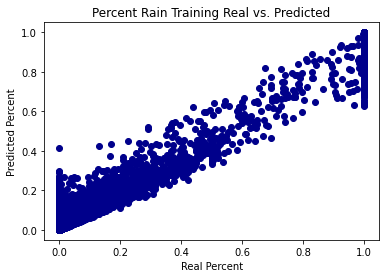

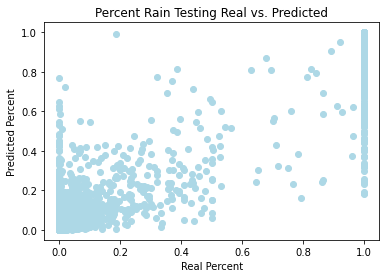

In [127]:
plt.scatter(train_y['PercentRain'], predict_train_y[:,0], color = "darkblue")
plt.title("Percent Rain Training Real vs. Predicted")
plt.xlabel("Real Percent")
plt.ylabel("Predicted Percent")
plt.show()

plt.scatter(test_y['PercentRain'], predict_test_y[:,0], color = "lightblue")
plt.title("Percent Rain Testing Real vs. Predicted")
plt.xlabel("Real Percent")
plt.ylabel("Predicted Percent")
plt.show()

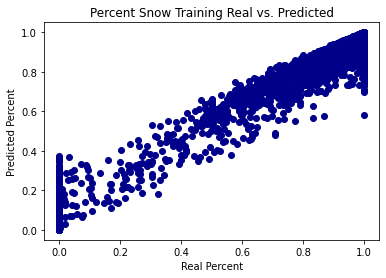

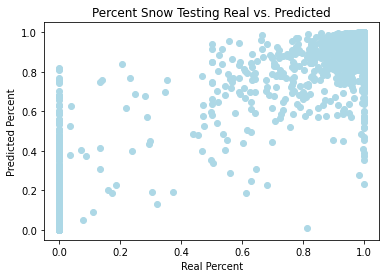

In [128]:
plt.scatter(train_y['PercentSnow'], predict_train_y[:,1], color = "darkblue")
plt.title("Percent Snow Training Real vs. Predicted")
plt.xlabel("Real Percent")
plt.ylabel("Predicted Percent")
plt.show()

plt.scatter(test_y['PercentSnow'], predict_test_y[:,1], color = "lightblue")
plt.title("Percent Snow Testing Real vs. Predicted")
plt.xlabel("Real Percent")
plt.ylabel("Predicted Percent")
plt.show()